In [1]:
# Author: Antti Kiviaho
# Date: 28.7.2022
#
# Sandbox to try out averaging tile-level predictions to sample level

In [1]:
import os
import sys
from logzero import logger
from matplotlib import pyplot as plt
from itertools import cycle
from scipy import stats

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from enum import IntEnum

from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator

from keras.models import load_model

from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

class toIntEnum(IntEnum):
    MED12 = 0
    HMGA2 = 1
    UNK = 2
    HMGA1 = 3
    OM = 4
    YEATS4 = 5


In [2]:
res_sheets = ['multiclass_fold_1_missing_2_epochs_100_percent_21939635_at_2022-07-15_21:45:39_598px_multiclass_prediction_results.csv',
              'multiclass_fold_2_missing_2_epochs_100_percent_21939634_at_2022-07-15_12:05:59_598px_multiclass_prediction_results.csv',
              'multiclass_fold_3_missing_2_epochs_100_percent_21939633_at_2022-07-15_14:57:30_598px_multiclass_prediction_results.csv',
              'multiclass_fold_4_missing_2_epochs_100_percent_21939632_at_2022-07-15_16:04:26_598px_multiclass_prediction_results.csv',
              'multiclass_folds_1-4_2_epochs_100_percent_21892820_at_2022-07-04_09:01:38_598px_multiclass_prediction_results.csv']

info_sheets = ['fold_1_tfr_contents.tsv',
              'fold_2_tfr_contents.tsv',
              'fold_3_tfr_contents.tsv',
              'fold_4_tfr_contents.tsv',
              'fold_5_tfr_contents.tsv']

all_results = pd.DataFrame()
for i in range(len(res_sheets)):
    results = pd.read_csv('/lustre/scratch/kiviaho/myoma/myoma-new/'+res_sheets[i])

    tfrecord_contents = pd.read_csv('/lustre/scratch/kiviaho/myoma/myoma-new/'+info_sheets[i])
    tfrecord_contents = tfrecord_contents[:len(results)]

    results = results.rename(columns={'0': 0, '1': 1,'2': 2,'3': 3,'4': 4,'5': 5})
    results = pd.concat([tfrecord_contents.reset_index(drop=True), results], axis=1)
    results.dropna(inplace=True)

    all_results = pd.concat([results.reset_index(drop=True), all_results], axis=0)
    
    

In [3]:
results = all_results

2022-07-29 13:42:39.008153: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/opt/cuda-11.2/lib64
2022-07-29 13:42:39.008228: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-29 13:42:39.008278: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (narvi-shell.cc.tut.fi): /proc/driver/nvidia/version does not exist
2022-07-29 13:42:39.008999: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


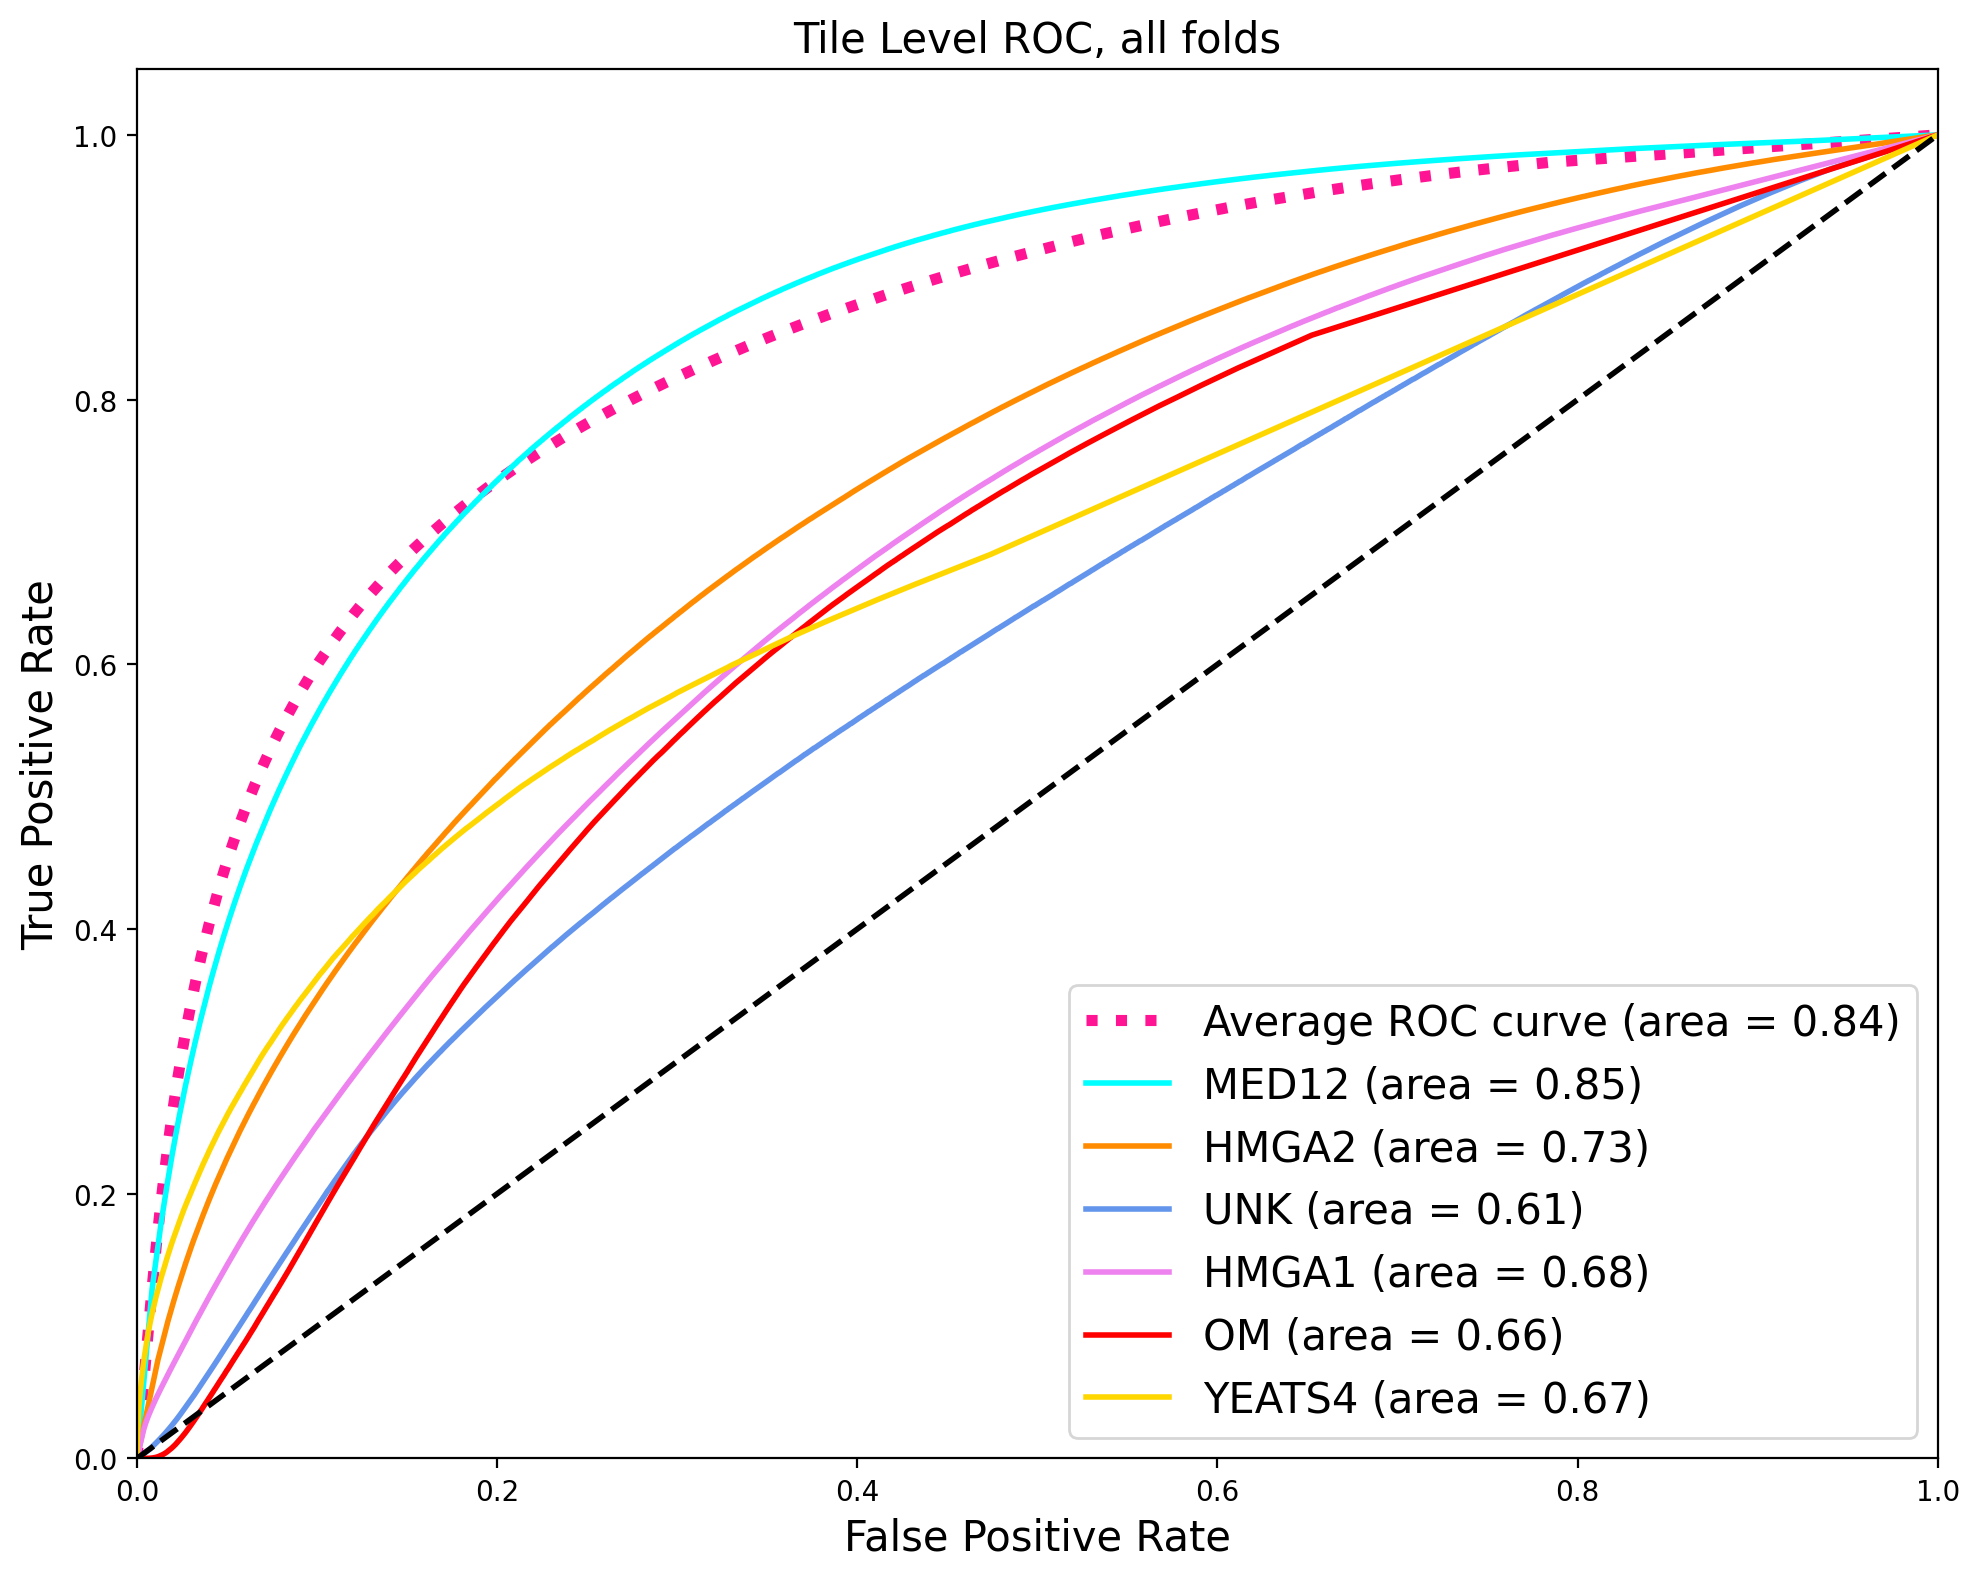

In [4]:
n_classes = 6
target_names = ['MED12', 'HMGA2', 'UNK', 'HMGA1', 'OM', 'YEATS4']
lw = 1

results_mod = results
gt_tile_mod = np.squeeze(np.array(results_mod['Label'],dtype=np.int16))

gt_tile_mod = np.array(tf.one_hot(gt_tile_mod,n_classes),dtype=np.int16)
results_mod = np.array(results_mod.loc[:,[0,1,2,3,4,5]],dtype=np.float32)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(gt_tile_mod[:, i], results_mod[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(gt_tile_mod.ravel(), results_mod.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

lw = 2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8), dpi=200)
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="Average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)


colors = cycle(["aqua", "darkorange", "cornflowerblue",'violet','red','gold'])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label= target_names[i] + " (area = %0.2f)" % roc_auc[i],
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw,)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate",size=15)
plt.ylabel("True Positive Rate",size=15)
plt.title("Tile Level ROC, all folds",size=15)
plt.legend(loc="lower right",prop={'size': 15})
plt.tight_layout()
#plt.savefig(filename + '_ROC_tile_level.png', dpi=300)


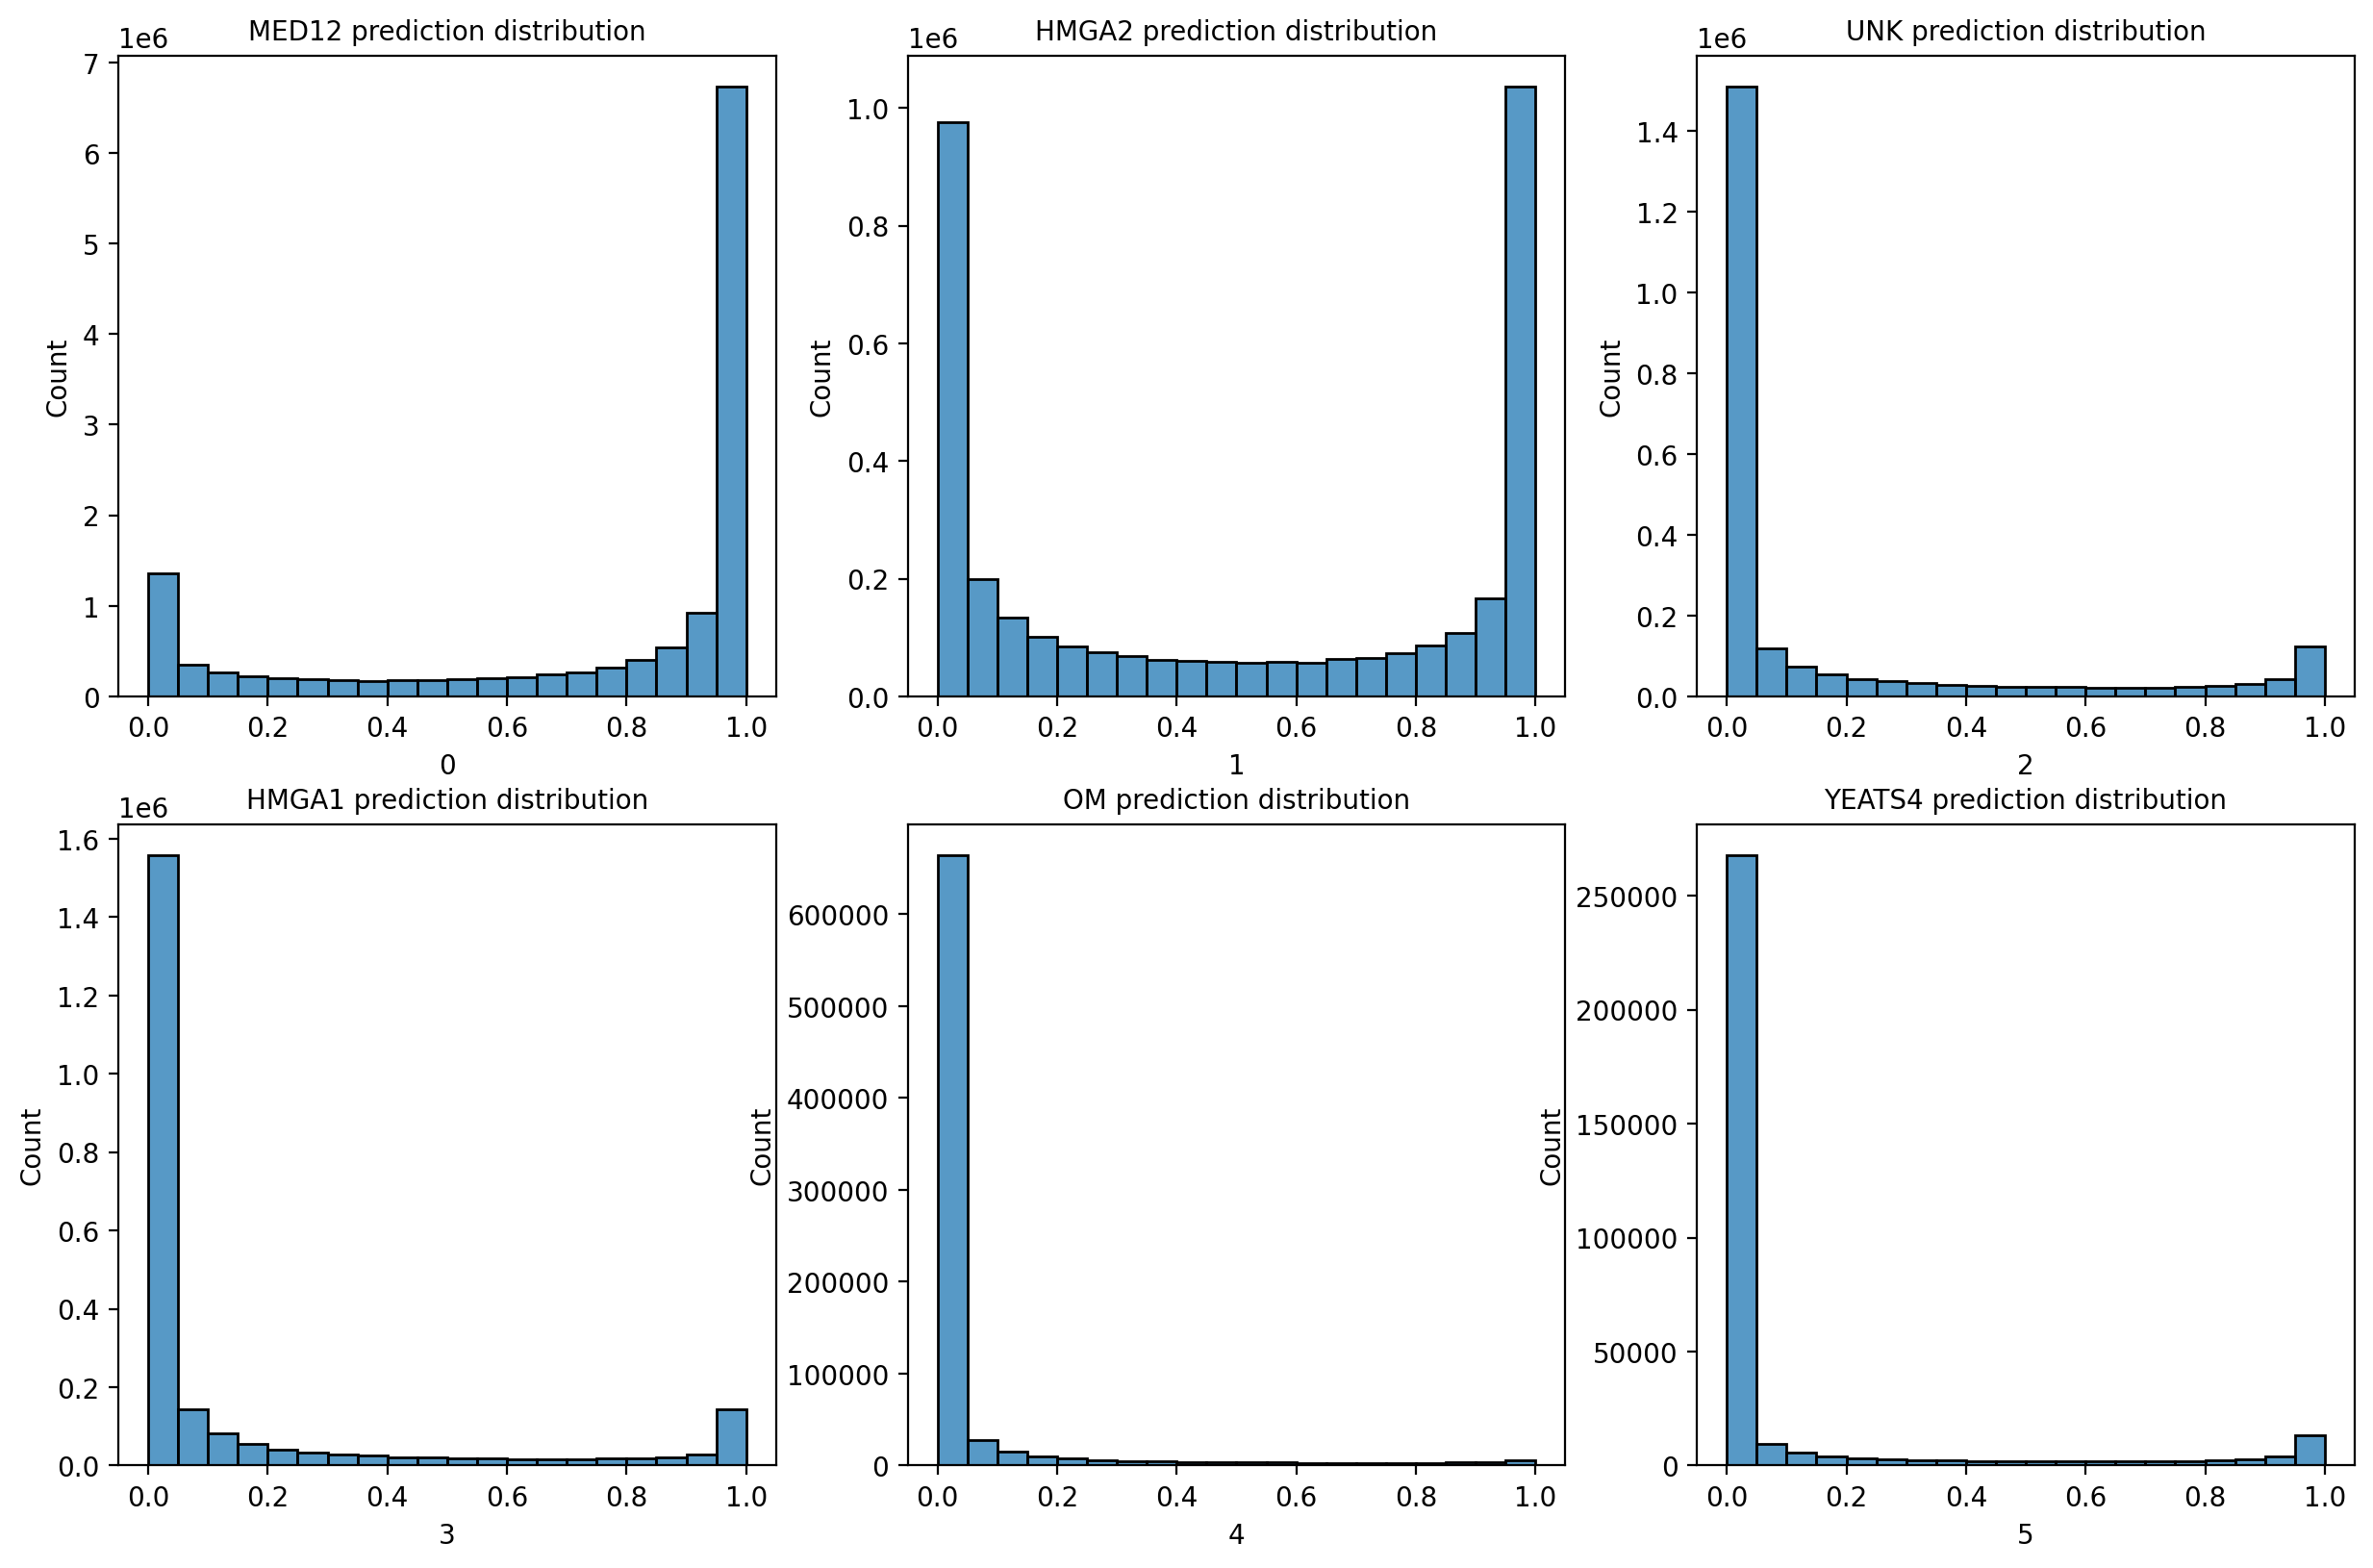

In [5]:
plt.figure(figsize=(15,15),dpi=200)

for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    sns.histplot(results[results['Label']== i][i],binwidth=0.05)
    plt.title(str(toIntEnum(i).name) +' prediction distribution',fontsize=10)
    i+=1


In [8]:
# # Find rows with certain prediction and get the class
# # Alternative way of defining prediction results

# df = np.empty((len(results)))
# df[:] = np.nan
# df[np.where(results.loc[:,[0,1,2,3,4,5]] >0.8)[0]] = np.where(results.loc[:,[0,1,2,3,4,5]] >0.8)[1]
# results['Certain'] = df

# sample_level =results.groupby(['Sample'])['Label','Certain'].agg(pd.Series.mode)
# predictions = sample_level['Certain']

In [10]:
sample_level = results.loc[:,['Sample','Label',0,1,2,3,4,5]].groupby(['Sample']).mean()


/home/ak431480/.conda/envs/myoma-new-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


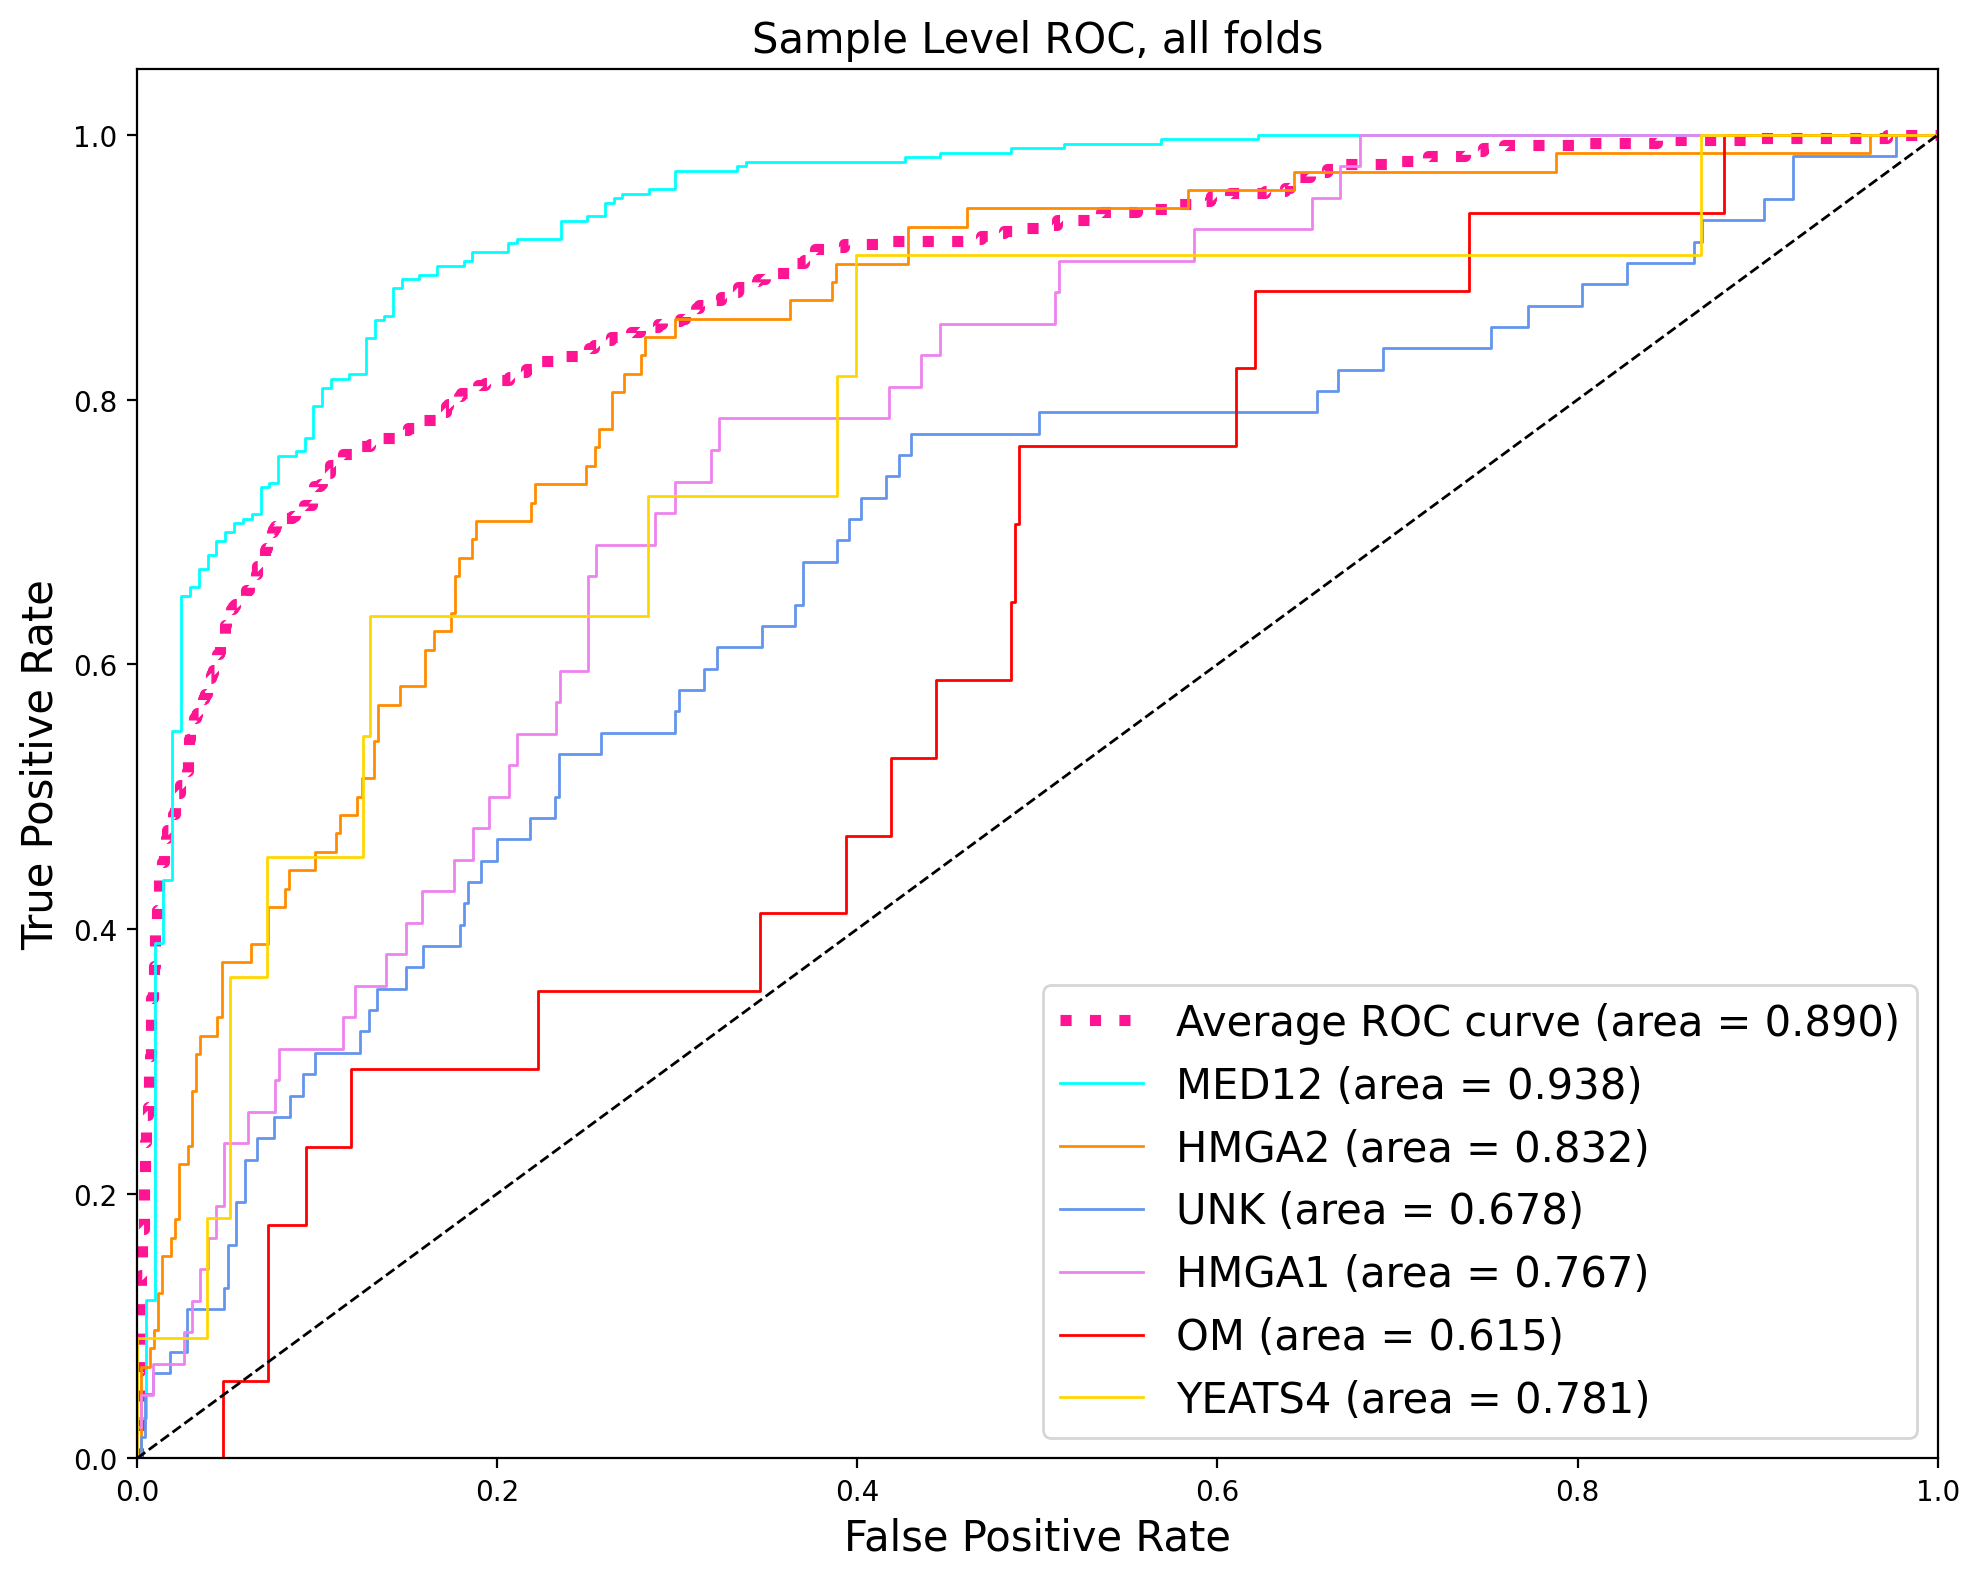

In [12]:
n_classes = 6
target_names = ['MED12', 'HMGA2', 'UNK', 'HMGA1', 'OM', 'YEATS4']
lw = 1

results_mod = sample_level
gt_sample_mod = np.squeeze(np.array(results_mod['Label'],dtype=np.int16))

gt_sample_mod = np.array(tf.one_hot(gt_sample_mod,n_classes),dtype=np.int16)
results_mod = np.array(results_mod.loc[:,[0,1,2,3,4,5]],dtype=np.float32)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(gt_sample_mod[:, i], results_mod[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(gt_sample_mod.ravel(), results_mod.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8), dpi=200)
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="Average ROC curve (area = {0:0.3f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)


colors = cycle(["aqua", "darkorange", "cornflowerblue",'violet','red','gold'])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label= target_names[i] + " (area = %0.3f)" % roc_auc[i],
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate",size=15)
plt.ylabel("True Positive Rate",size=15)
plt.title("Sample Level ROC, all folds",size=15)
plt.legend(loc="lower right",prop={'size': 15})
plt.tight_layout()
#plt.savefig(filename + '_ROC_sample_level.png', dpi=300)

[D 220729 11:14:16 2745348936:8] Confusion Matrix
[D 220729 11:14:16 2745348936:20] Classification Report


[[270  15   3   0   5   0]
 [ 16  41   6   4   5   0]
 [ 20  21  15   5   1   0]
 [  6  15  16   4   1   0]
 [  5   6   1   5   0   0]
 [  2   3   5   0   0   1]]
              precision    recall  f1-score   support

 MED12 (293)      0.846     0.922     0.882       293
  HMGA2 (72)      0.406     0.569     0.474        72
    UNK (62)      0.326     0.242     0.278        62
  HMGA1 (42)      0.222     0.095     0.133        42
     OM (17)      0.000     0.000     0.000        17
 YEATS4 (11)      1.000     0.091     0.167        11

    accuracy                          0.666       497
   macro avg      0.467     0.320     0.322       497
weighted avg      0.639     0.666     0.638       497



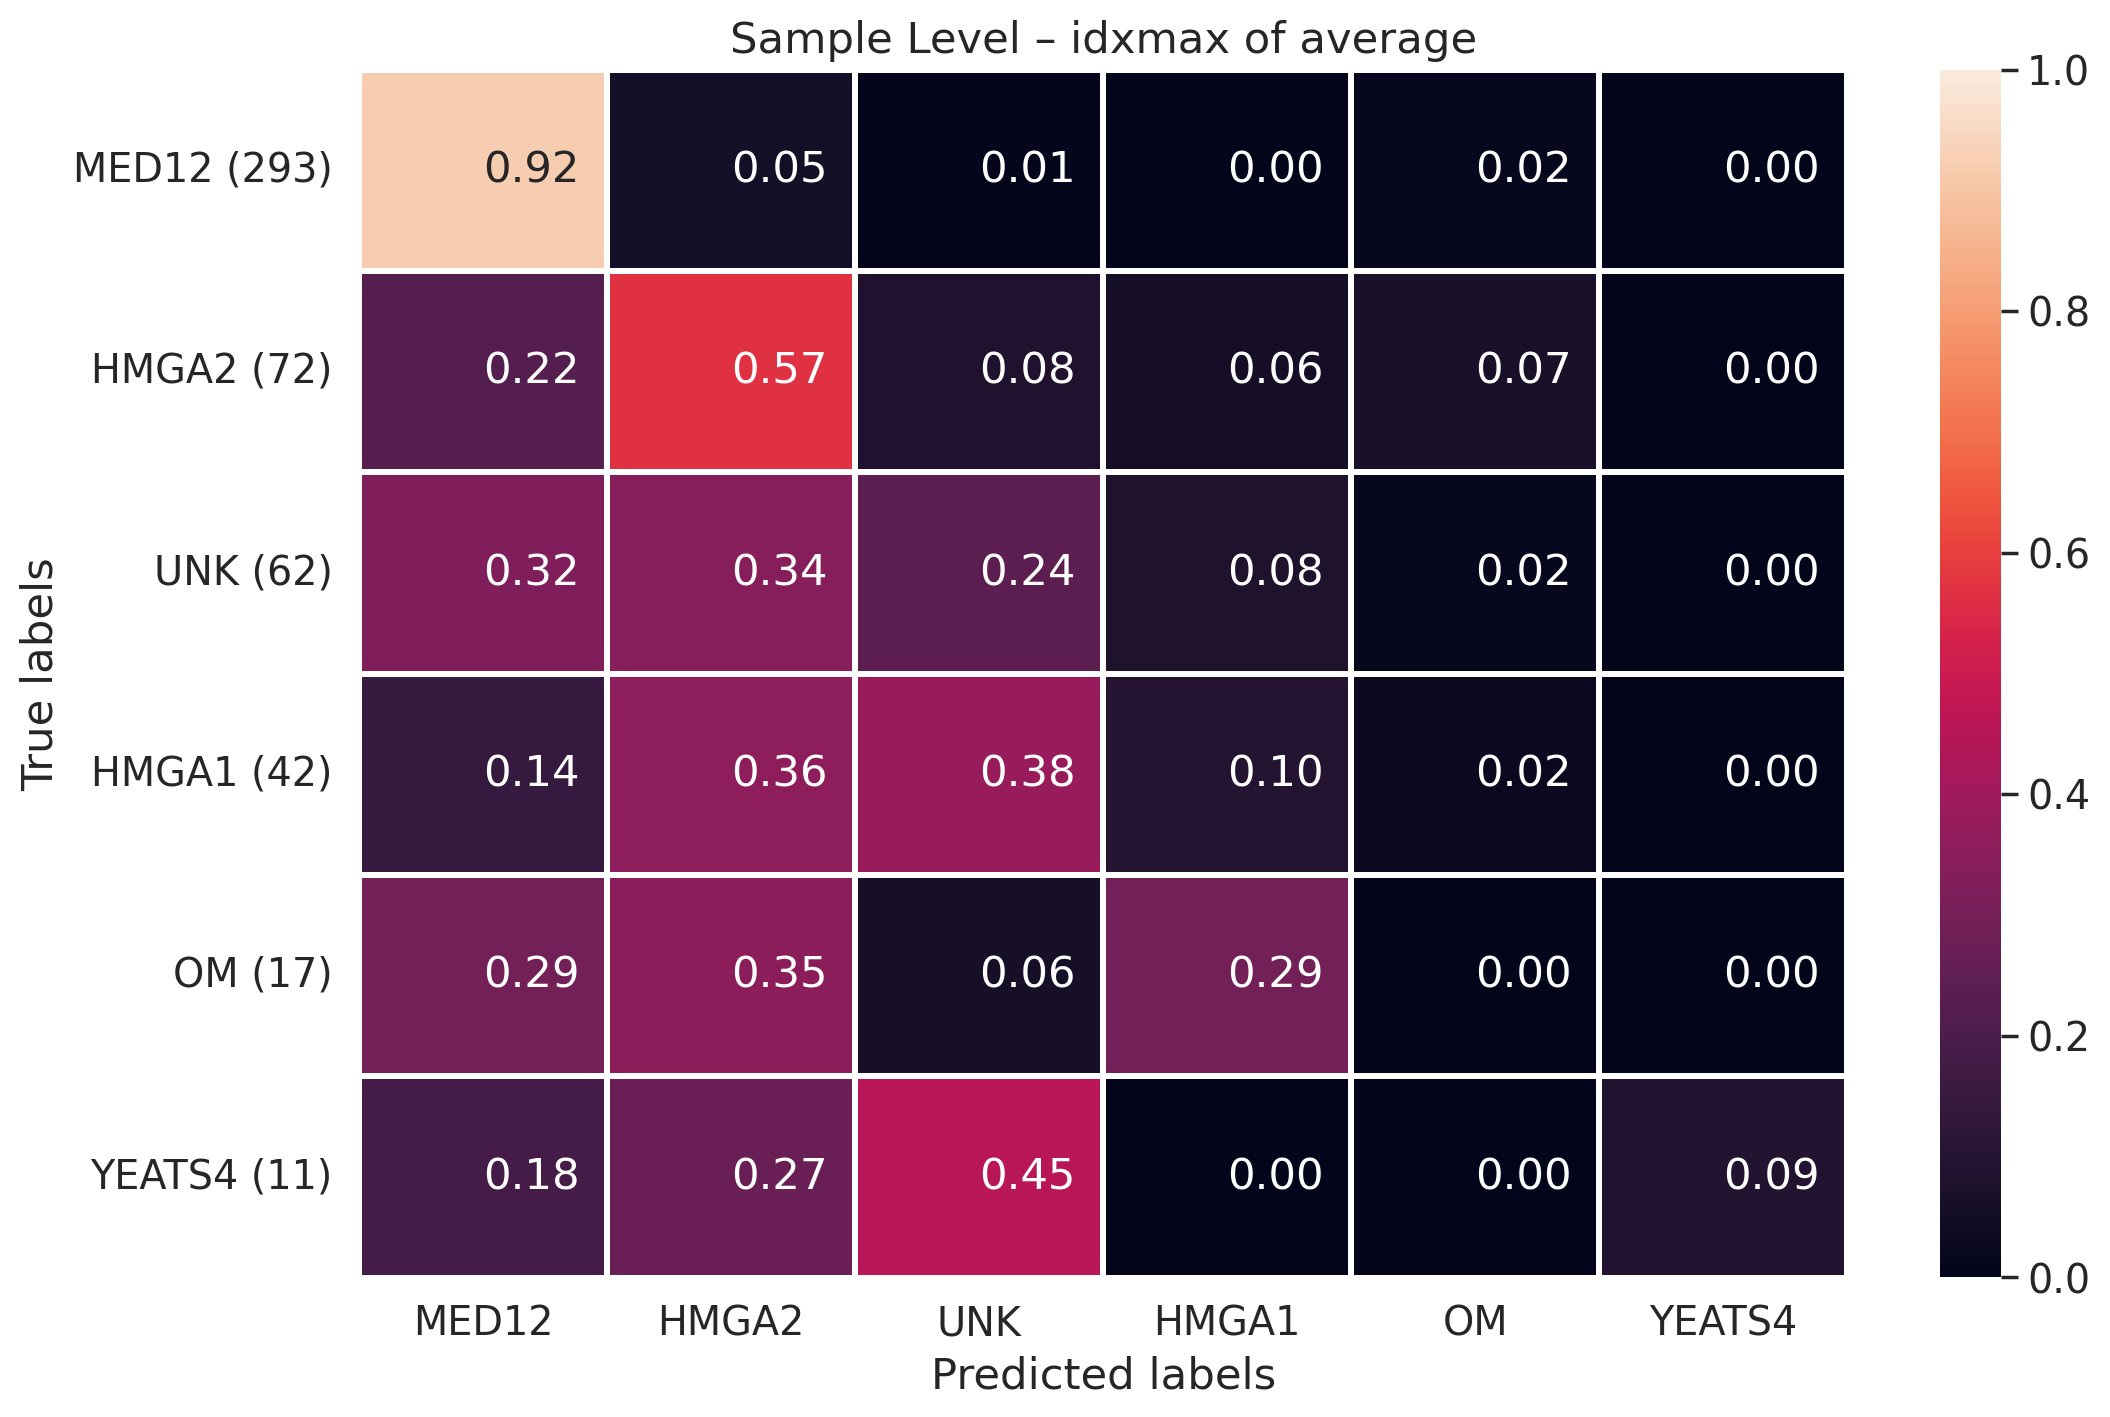

In [137]:
gt_sample = sample_level.loc[:,['Label']]

# get predictions into single column
# for confusion matrix
predictions = sample_level.loc[:,[0,1,2,3,4,5]].idxmax(axis= 1)


logger.debug("Confusion Matrix")
cm = confusion_matrix(gt_sample, predictions)
print(cm)

target_names = ['MED12 ({:})'.format(np.sum(cm[0,:])),
                'HMGA2 ({:})'.format(np.sum(cm[1,:])),
                'UNK ({:})'.format(np.sum(cm[2,:])),
                'HMGA1 ({:})'.format(np.sum(cm[3,:])),
                'OM ({:})'.format(np.sum(cm[4,:])),
                'YEATS4 ({:})'.format(np.sum(cm[5,:])),]
predict_names = ['MED12', 'HMGA2', 'UNK', 'HMGA1', 'OM', 'YEATS4']

logger.debug("Classification Report")
cr = classification_report(gt_sample, predictions,
                            target_names=target_names,digits=3)
print(cr)

ax1 = plt.subplot(111)


akws = {"ha": 'left',"va": 'center'}
cm = cm/cm.sum(axis=1, keepdims=True)
sns.set_theme(font_scale=1.3)
sns.heatmap(cm, annot=cm, ax = ax1, fmt='.2f', annot_kws=akws,linewidths=2,
            cbar =True, linecolor='white', vmin=0.,vmax=1.)


# sns.set_theme(font_scale=1.)
# sns.heatmap(cm, annot=cm, ax = ax1, fmt='d',linewidths=2,
#             cbar =True, linecolor='white')


# labels, title and ticks
ax1.set_xlabel('Predicted labels')
ax1.set_ylabel('True labels')
ax1.set_title("Sample Level â€“ idxmax of average")
ax1.xaxis.set_ticklabels(predict_names)
ax1.yaxis.set_ticklabels(target_names,rotation=0)
ax1.figure.set_size_inches((12,8))
ax1.figure.set_dpi(200)



